# **Assignment 3 - Pattern Recogonition Course**

## Speech Emotion Recogonition

#### Libraries to be imported

In [51]:

!pip install pytorch-lightning

/bin/bash: py: command not found


In [21]:
import os
import wave
import numpy as np
import pandas as pd
import sys
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD
from torchvision import models
from torch.utils.data import DataLoader
from scipy.io.wavfile import read

import IPython.display as ipd
import pytorch_lightning as pl
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Download the Dataset and Understand the Format (10 Points)
#### a. We will use CREMA dataset that is available at the following link: 
https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en

In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
y_dataset = []
audios = []
sample_rates = []
for dirname, _, filenames in os.walk('/kaggle/input/speech-emotion-recognition-en/Crema'):
    for filename in filenames:
        #Join directories
        wavfileName = str(os.path.join(dirname, filename))
        #Get the emotion type from the name of the wave file
        y_dataset.append(wavfileName.split('_')[2])
        #load .wav file
        waveform, sample_rate = librosa.load(wavfileName)
        #Append Waveforms
        audios.append(waveform)
        #Append new sample rate
        sample_rates.append(sample_rate)
        wav_file.close()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [69]:
# Print length of dataset
print(len(audios))
print(audios[2].shape)

7442
(57388,)


#### b. Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio. 

In [44]:
def plot_waveform(audio_frames,class_name):
    plt.plot(audio_frames)
    # Set the title and labels
    plt.title("Waveform of {0}".format(class_name))
    plt.xlabel("Time (miliseconds)")
    plt.ylabel("Amplitude")
    # Show the plot
    plt.show()

The waveform of random class SAD


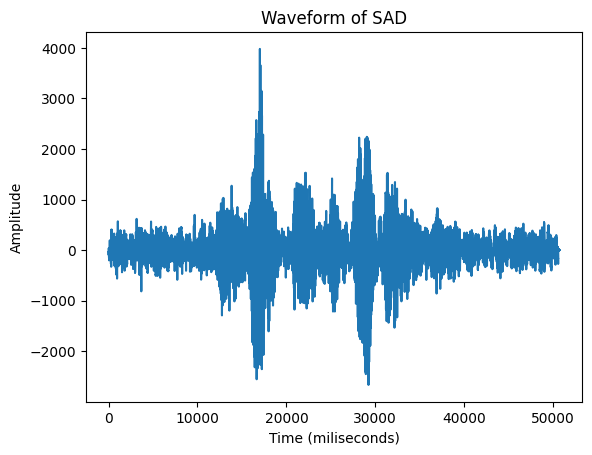

The waveform of random class DIS


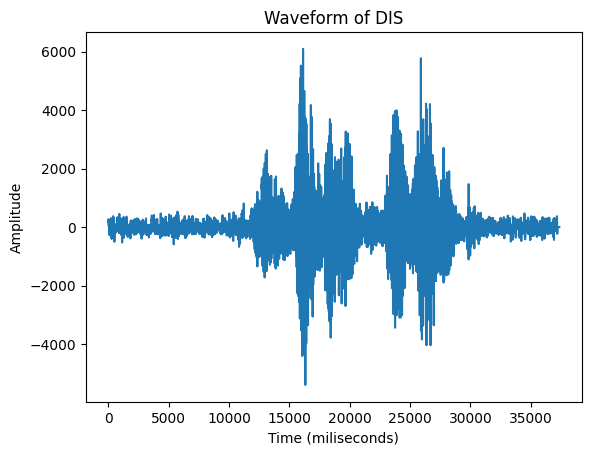

The waveform of random class FEA


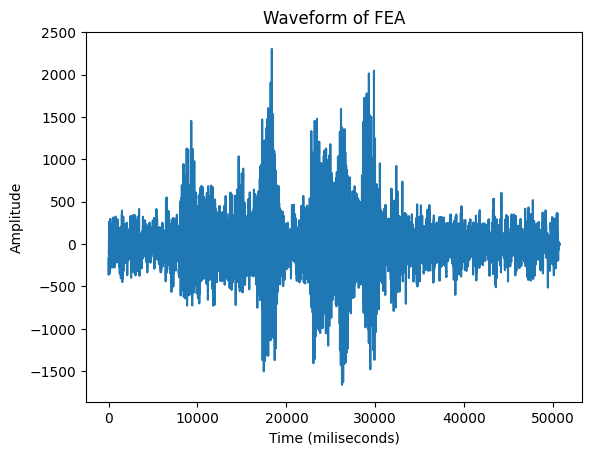

The waveform of random class ANG


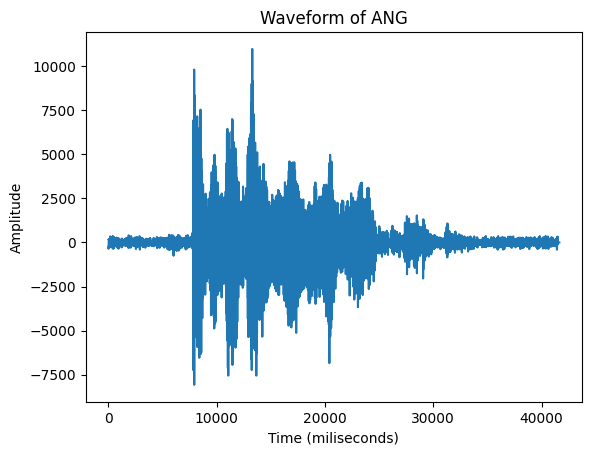

The waveform of random class NEU


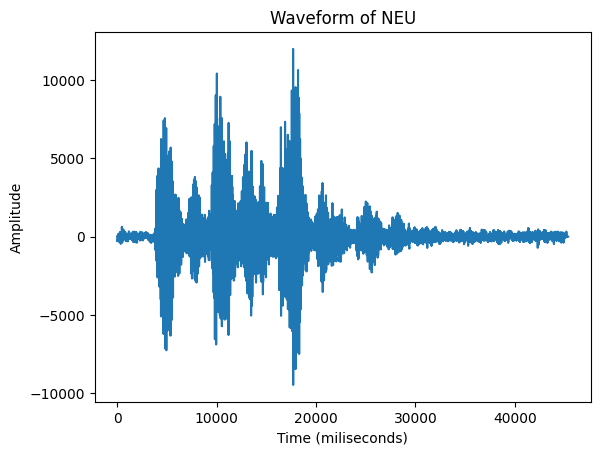

The waveform of random class HAP


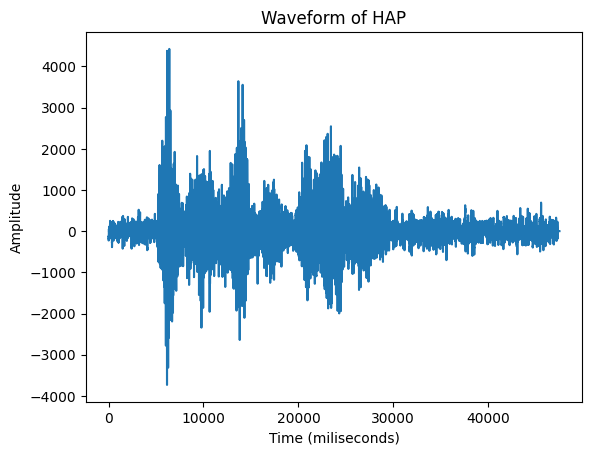

In [45]:
# Random plotting of different waveforms from each class
features = set(y_dataset)
y_dataset = np.array(y_dataset)
random_picks = []
for feature in features:
    feature_indices = np.where(y_dataset == feature)
    random = np.random.choice(list(feature_indices)[0])
    random_picks.append(random)
    print("The waveform of random class {0}".format(feature))
    plot_waveform(dataset[random],feature)

#### Playing audios from different classes

In [46]:
# I tried to use pyaudio and playground but kaggle does not support
print("audio for random class {0}".format(list(features)[0]))
ipd.Audio(data=audios[random_picks[0]], rate = sample_rates[random_picks[0]], autoplay=False)

audio for random class SAD


In [47]:
print("audio for random class {0}".format(list(features)[1]))
ipd.Audio(data=audios[random_picks[1]], rate = sample_rates[random_picks[1]], autoplay=False)

audio for random class DIS


In [48]:
print("audio for random class {0}".format(list(features)[2]))
ipd.Audio(data=audios[random_picks[2]], rate = sample_rates[random_picks[2]], autoplay=False)

audio for random class FEA


In [49]:
print("audio for random class {0}".format(list(features)[3]))
ipd.Audio(data=audios[random_picks[3]], rate = sample_rates[random_picks[3]], autoplay=False)

audio for random class ANG


In [50]:
print("audio for random class {0}".format(list(features)[4]))
ipd.Audio(data=audios[random_picks[4]], rate = sample_rates[random_picks[4]], autoplay=False)

audio for random class NEU


In [51]:
print("audio for random class {0}".format(list(features)[5]))
ipd.Audio(data=audios[random_picks[5]], rate = sample_rates[random_picks[5]], autoplay=False)

audio for random class HAP


## 2. Create the Feature Space (30 Points) 
#### a. You can work on time domain, or you can work in frequency domain. There are multiple of features that can help improving the model:

In [54]:
# Calculate the zero crossing rate
zcr_energy = np.empty((1,2))
for audio in audios:
        zcr_datapoint = np.count_nonzero(np.diff(audio) != 0)
        energy_datapoint = np.mean(audio ** 2)
        zcr_energy = np.vstack((zcr_energy, np.array([zcr_datapoint,energy_datapoint])))
zcr_energy = zcr_energy[1:]

#### b. Convert the audio waveform to mel spectrogram and use this as the feature space.

In [72]:
#it takes upto 7 minutes
mel_spectrograms = []
for waveform,sample_rate in zip(audios,sample_rates):
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
    mel_spectrograms.append(mel_spectrogram)

In [74]:
print(mel_spectrograms[7].shape)

(128, 130)
